# Data Science and Visualization (RUC F2025)

## Miniproject Report

## Project Title: Predicting Podcast Listening Time. Kaggle Competition.

## Group Members:
* Vladyslav Horbatenko, Computer Science and Mathematics, 2025, vladyslav@ruc.dk

## Abstract

This project aimed to predict how long people listen to podcast episodes using a dataset from a Kaggle competition. I looked at various details like episode length, who was hosting or guesting, when it was published, and other characteristics. The main goal was to figure out what factors really influence how long someone stays tuned in and to build a model that could accurately guess the listening time. I started by exploring the data to understand it better, then prepared it by cleaning up issues and creating new features. For the prediction part, I primarily used an XGBoost model, comparing its performance to a simpler linear regression.

## 0. Setup and Data

Import the modules needed for the project.

In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score


import optuna
import xgboost as xgb
from xgboost import XGBRegressor

---
### Data Description

The dataset used in this report comes from the Kaggle Playground Series S5E4 competition (https://www.kaggle.com/competitions/playground-series-s5e4/data). According to the competition organizers, it was generated by a deep learning model trained on the [Podcast Listening Time Prediction](https://www.kaggle.com/datasets/ysthehurricane/podcast-listening-time-prediction-dataset/) dataset. This means the data I used looks a lot like the original, but it's not exactly the same.


Remark: In this report, I'll talk about splitting data into training and testing sets using the original dataset idea. But all the actual looking at the data and building the model was done using the competition dataset that was already split up.


#### Files

- **train.csv** – Training data; the target variable is `Listening_Time_minutes`.  
- **test.csv** – Test data; your goal is to predict `Listening_Time_minutes` for each entry.  
- **sample_submission.csv** – Example submission file in the correct format.  

#### Reference

Walter Reade and Elizabeth Park. *Predict Podcast Listening Time*. Kaggle Competition: Playground Series S5E4. 2025. https://www.kaggle.com/competitions/playground-series-s5e4

---

## 1. Loading the Data

1. Loading the DataWhile I could use the Kaggle API to get these files automatically, for simplicity, I decided to download them straight from the competition page and save them in a local `data/` folder. If the competition data happens to change, or if you prefer, you can always get the latest version by cloning my GitHub repository here: https://github.com/rifolio/PodcastWatchTimePrediction


I will start by loading original dataset using pandas `read_csv` method, and `train_test_split` to split it into train and test and submission dataframes, to showcase logic that organizers used to create such split

In [2]:
# loading origin dataset
original_data = pd.read_csv('data/podcast_dataset.csv')

# making sure no missing values are present in the target variable
original_data = original_data.dropna(subset=['Listening_Time_minutes'])

# adding an ID column as it doesn't exist in original dataset
original_data = original_data.reset_index().rename(columns={'index': 'ID'})

# randomly selcting 1,000 rows for submission
submission = original_data.sample(n=1000, random_state=42)[['ID', 'Listening_Time_minutes']]


# features (X) and target (y)
X = original_data.drop(columns=['Listening_Time_minutes'])
y = original_data['Listening_Time_minutes']

# train-test split for rest of data with 20/80 split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Submission set size:", submission.shape)
print("Training set size:", X_train.shape)
print("Validation set size:", X_valid.shape)

Submission set size: (1000, 2)
Training set size: (14072, 11)
Validation set size: (3518, 11)


This demonstrates how we could simulate a train/test split from the original dataset. However, since the competition dataset is more extensive and better aligned with the task requirements (synthetically generated), I will use the official competition split for all further analysis and modeling combined with `podcast_dataset.csv` with train split

In [3]:
test = pd.read_csv('data/test.csv') 
train_df = pd.read_csv('data/train.csv')
submission = pd.read_csv('data/sample_submission.csv')

# combining train and original data
train_df = pd.concat([train_df, original_data], ignore_index=True)
train_df.drop(columns=['id', 'ID'], inplace=True)

# drop duplicate samples in case some
train = train_df.drop_duplicates()

In [4]:
# overall statistics about data
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Submission shape:", submission.shape)

Train shape: (767590, 11)
Test shape: (250000, 11)
Submission shape: (250000, 2)


In [5]:
train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [6]:
test.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
dtype: object

So far, all datatypes are in place.

In [7]:
train.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,678727.000000,767590.000000,619834.000000,767589.000000,767590.000000
mean,64.466083,59.866318,52.181816,1.352360,45.437908
std,32.971460,22.880310,28.460765,1.150496,27.137015
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.710000,39.430000,28.290000,0.000000,23.180910
50%,63.820000,60.060000,53.460000,1.000000,43.390230
75%,94.040000,79.540000,76.560000,2.000000,64.804950
max,325.240000,119.460000,119.910000,103.910000,119.970000


In [8]:
test.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,250000.000000,2.212640e+05,250000.000000,201168.000000,250000.000000
mean,874999.500000,4.192987e+02,59.716491,52.192796,1.355852
std,72168.927986,1.668545e+05,22.880028,28.445034,4.274399
min,750000.000000,2.470000e+00,2.490000,0.000000,0.000000
25%,812499.750000,3.578000e+01,39.250000,28.320000,0.000000
50%,874999.500000,6.397000e+01,59.900000,53.360000,1.000000
75%,937499.250000,9.415000e+01,79.390000,76.560000,2.000000
max,999999.000000,7.848626e+07,117.760000,116.820000,2063.000000


## 2. Data Preprocessing

Since competition have already provided us with `train` and `test` datasets, I will mainly focus on `train` dataset in the analysis.

### Handling Missing Values

In [67]:
# for usability, I will define function that shows missing values in a any dataframe
def show_missing(df, name="DataFrame"):
    missing = df.isnull().sum() 
    missing_percent = df.isnull().mean()

    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': (missing_percent * 100).round(2)
    })

    # only showing column that have missing values
    missing_df = missing_df[missing_df['Missing Count'] > 0]

    if missing_df.empty:
        print(f"No missing values in {name}.")
    else:
        print(f"Missing values in {name}:")
        print(missing_df.sort_values(by="Missing Count", ascending=False))

show_missing(train, "Train Set")
show_missing(test, "Test Set")


No missing values in Train Set.
No missing values in Test Set.


#### Episode Duration

A notable portion of `Episode_Length_minutes` is missing, making imputation necessary to avoid losing valuable data. While the **global median** is a common method that is less affected by outliers, it may overlook podcast-specific patterns.

Since podcasts often follow consistent episode durations, i need to evaluate whether **per-podcast medians** vary significantly (its STD).

In [10]:
# global median
global_median = train['Episode_Length_minutes'].median()

# median per podcast
podcast_medians = train.groupby('Podcast_Name')['Episode_Length_minutes'].median()
median_std = podcast_medians.std()

print("Global median:", global_median)
print("Std of medians per podcast:", median_std)

Global median: 63.82
Std of medians per podcast: 2.2207980658317688


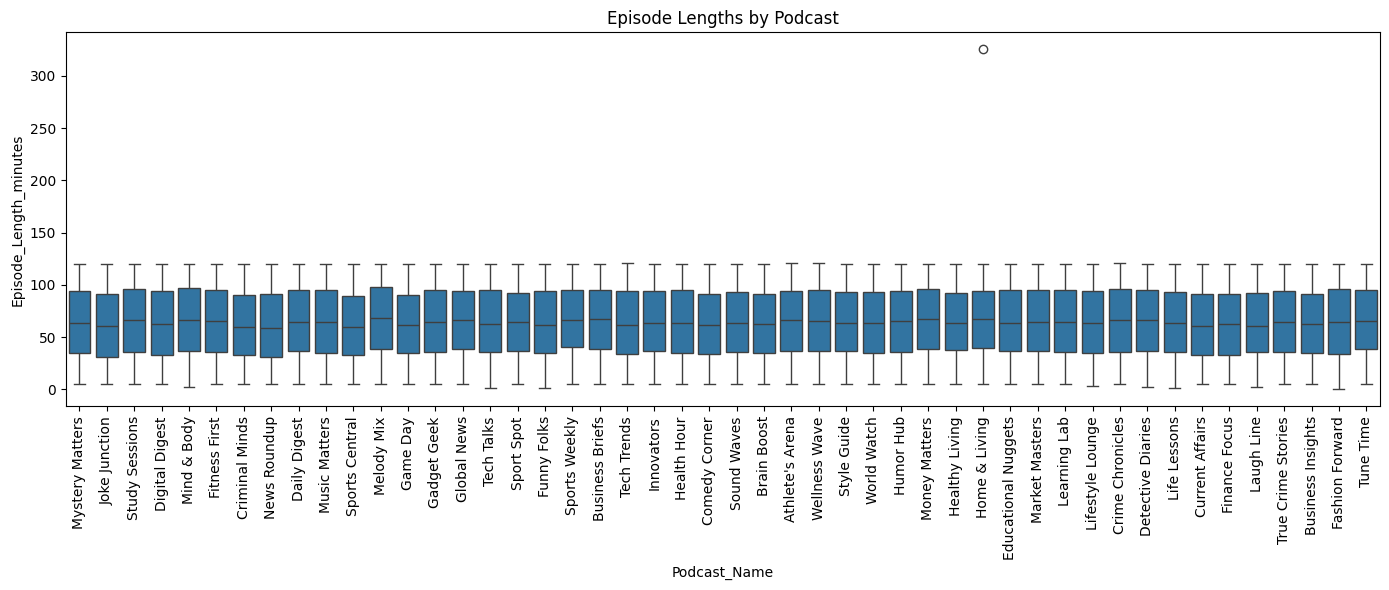

In [11]:
# boxplot of episode lengths for all podcasts
plt.figure(figsize=(14, 6))
sns.boxplot(data=train, x='Podcast_Name', y='Episode_Length_minutes')

plt.xticks(rotation=90)
plt.title("Episode Lengths by Podcast")
plt.tight_layout()
plt.show()


Now I can see that both, data and plot shows that variation across podcast medians is small (std = 2.22), and the global distribution is well-centered.

Meaning that imputing missing values with the **global median** is well justified.


In [12]:
median_length = train['Episode_Length_minutes'].median()
train['Episode_Length_minutes'] = train['Episode_Length_minutes'].fillna(median_length)
test['Episode_Length_minutes'] = test['Episode_Length_minutes'].fillna(median_length)

#### Guest Popularity

`Guest_Popularity_percentage` has ~19% missing values. To decide how to impute them, I will analyse the impact of missing data on listening behavior.

In [13]:
# making temporary copy of train set to analyze missing values
temp = train.copy()
temp['Guest_Missing'] = temp['Guest_Popularity_percentage'].isna().astype(int)

# listening time with and without missing guest info
summary = temp.groupby('Guest_Missing')['Listening_Time_minutes'].describe()

summary

,count,mean,std,min,25%,50%,75%,max
Guest_Missing,,,,,,,,
0,619834.0,45.474773,27.173711,0.0,23.09894,43.29822,64.83828,119.97
1,147756.0,45.283261,26.982078,0.0,23.42442,43.67298,64.58644,119.97


The distributions of `Listening_Time_minutes` are almost identical across both groups. Mening that missing guest popularity is likely just incomplete data.

So, we can also use median per podcast or global median. Like in eposide length time, I will use global median.


In [14]:
guest_median = train['Guest_Popularity_percentage'].median()

# fill in nans
train['Guest_Popularity_percentage'] = train['Guest_Popularity_percentage'].fillna(guest_median)
test['Guest_Popularity_percentage'] = test['Guest_Popularity_percentage'].fillna(guest_median)


As I only have one missing value for `Number_of_Ads`, removal of will not have big impact on results, so I will just drop it.

In [15]:
train = train[train['Number_of_Ads'].notna()]
test = test[test['Number_of_Ads'].notna()]

Lets now check datasts summary again:

In [16]:
show_missing(train, "Train Set")
show_missing(test, "Test Set")

No missing values in Train Set.
No missing values in Test Set.


## 3. Exploratory Data Analysis


Before going deeper into EDA and making any assumptions, I will look into unique values for each category to see what might be important to focus on.

### Questions To Look Into:

- What is the distribution of the target variable (`Listening_Time_minutes`), and are there any noticeable skews?
- Are there any logical inconsistencies, such as listening time being greater than episode length?
- What are the most common publication days and times, and how do they affect average listening time?
- How does episode sentiment correlate with listener engagement?
- Are there any extreme values or outliers?
- What is the relationship between episode length and listening time?
- How are key numerical features (e.g., popularity percentages, number of ads) distributed?

In [17]:
# looking into unuque values
non_numeric_cols = train.select_dtypes(exclude=['number']).columns

for column in non_numeric_cols:
    unique_values = train[column].unique()
    print(f"{column} - {len(unique_values)} unique values")
    print(f"Examples: {unique_values[:5]}\n")

Podcast_Name - 48 unique values
Examples: ['Mystery Matters' 'Joke Junction' 'Study Sessions' 'Digital Digest'
 'Mind & Body']

Episode_Title - 100 unique values
Examples: ['Episode 98' 'Episode 26' 'Episode 16' 'Episode 45' 'Episode 86']

Genre - 10 unique values
Examples: ['True Crime' 'Comedy' 'Education' 'Technology' 'Health']

Publication_Day - 7 unique values
Examples: ['Thursday' 'Saturday' 'Tuesday' 'Monday' 'Sunday']

Publication_Time - 4 unique values
Examples: ['Night' 'Afternoon' 'Evening' 'Morning']

Episode_Sentiment - 3 unique values
Examples: ['Positive' 'Negative' 'Neutral']



Quick data integrity check. It might be the case, that because data is synthetic, it may have some wrong numbers. 

For example `Listening_Time_minutes` exceeds the actual `Episode_Length_minutes`. Since it's not possible to listen longer than the duration of the podcast, such rows are likely due to noise or synthetic generation errors and should be removed.


In [18]:
invalid_rows = train[train['Listening_Time_minutes'] > train['Episode_Length_minutes']]
print(f"Invalid rows found: {len(invalid_rows)}")

Invalid rows found: 22725


In [19]:
# remove these rows from the dataset
train = train[train['Listening_Time_minutes'] <= train['Episode_Length_minutes']]

In [20]:
numeric_features = [
    'Listening_Time_minutes',
    'Episode_Length_minutes',
    'Host_Popularity_percentage',
    'Guest_Popularity_percentage',
    'Number_of_Ads'
]

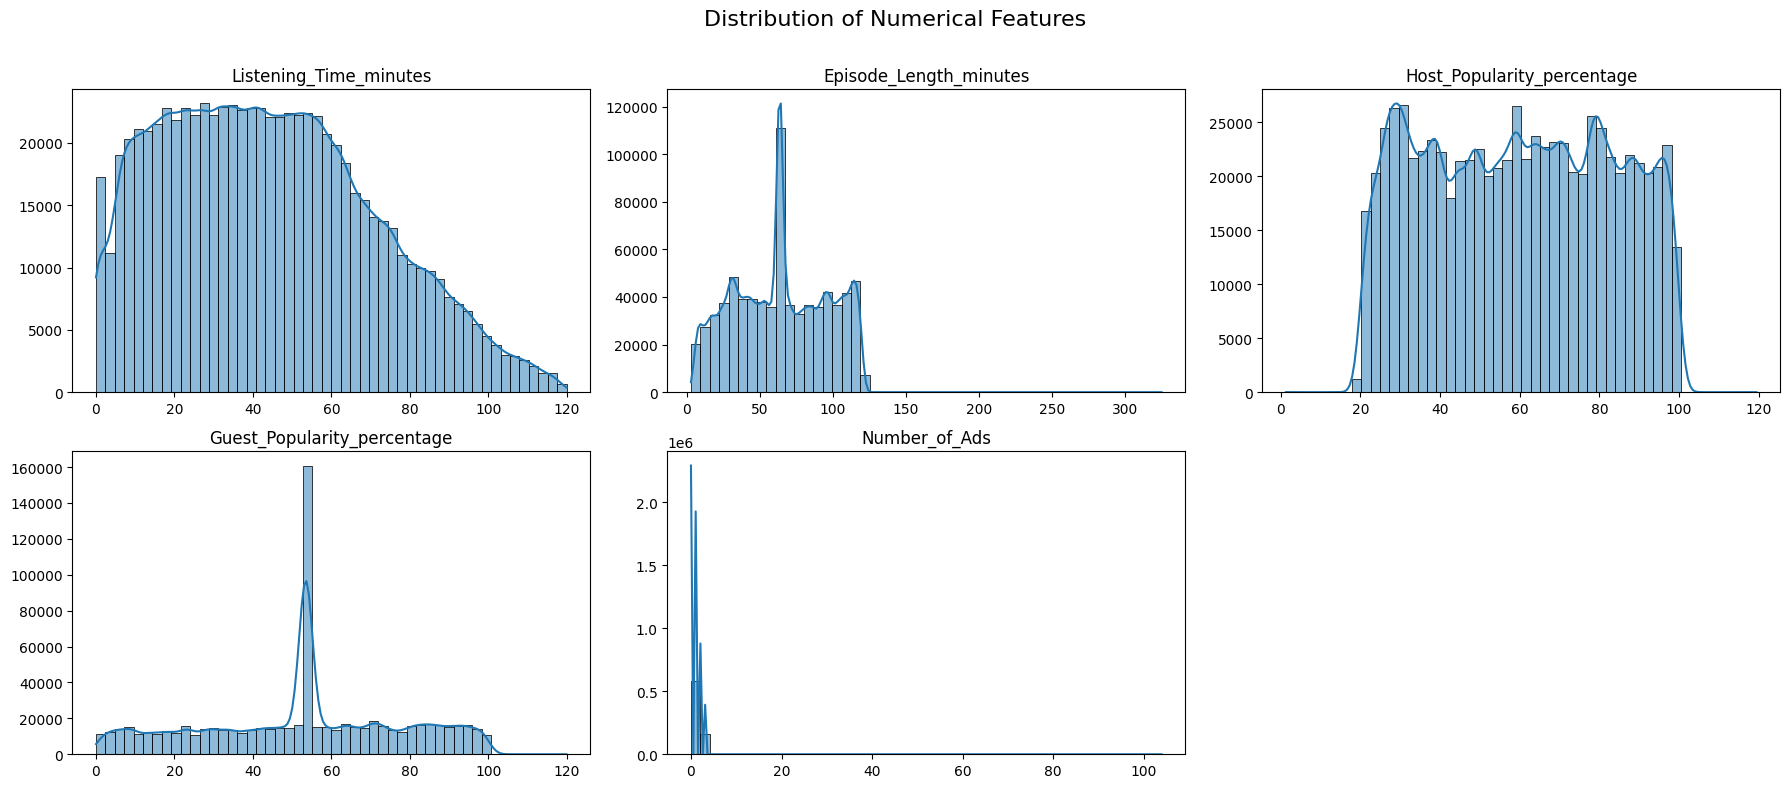

In [21]:
# using grid to plot multiple figures at once
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
fig.suptitle("Distribution of Numerical Features", fontsize=16)

# easy iteration
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(train[feature], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"{feature}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

if len(numeric_features) < len(axes):
    for j in range(len(numeric_features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # for title spacing
plt.show()


The target variable, `Listening_Time_minutes`, has a slightly left-skewed distribution, with most values falling between 20 and 80 minutes. This means that listeners often spend a good amount of time on episodes, while very long listening times are less common.

Features like `Episode_Length_minutes` and `Guest_Popularity_percentage` show sharp peaks, suggesting that many episodes have consistent lengths and guest popularity tends to cluster around certain values. On the other hand, `Host_Popularity_percentage` is spread more evenly, which could help the model learn from a wider range of values. Yet, I am concerned about values above 100%, which is unusual value for prcentage, I will investigate it further.

One feature that stands out is `Number_of_Ads`, which has a long right-skewed distribution and some very high values. These are likely outliers and could affect model performance. To explore this further, I will take a closer look at this feature using box plots.

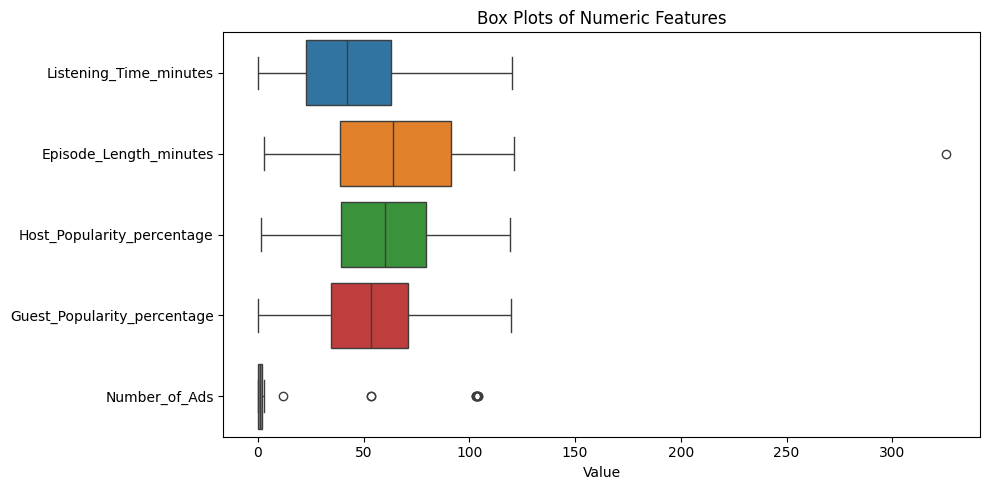

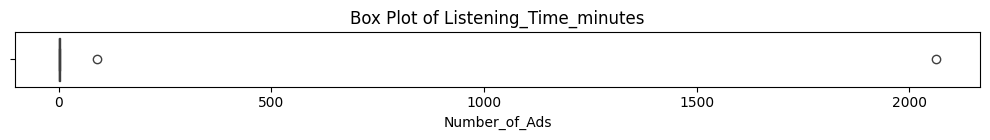

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=train[numeric_features], orient='h')
plt.title("Box Plots of Numeric Features")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 1.5))
sns.boxplot(x=test['Number_of_Ads'])
plt.title("Box Plot of Listening_Time_minutes")
plt.tight_layout()
plt.show()

In [23]:
train['Number_of_Ads'].value_counts().sort_index(), test['Number_of_Ads'].value_counts().sort_index()

(Number_of_Ads
 0.00      213272
 1.00      211603
 2.00      158372
 3.00      161608
 12.00          1
 53.37          1
 53.42          1
 103.00         1
 103.25         2
 103.75         1
 103.88         1
 103.91         1
 Name: count, dtype: int64,
 Number_of_Ads
 0.00       72863
 1.00       71015
 2.00       52564
 3.00       53556
 89.12          1
 2063.00        1
 Name: count, dtype: int64)

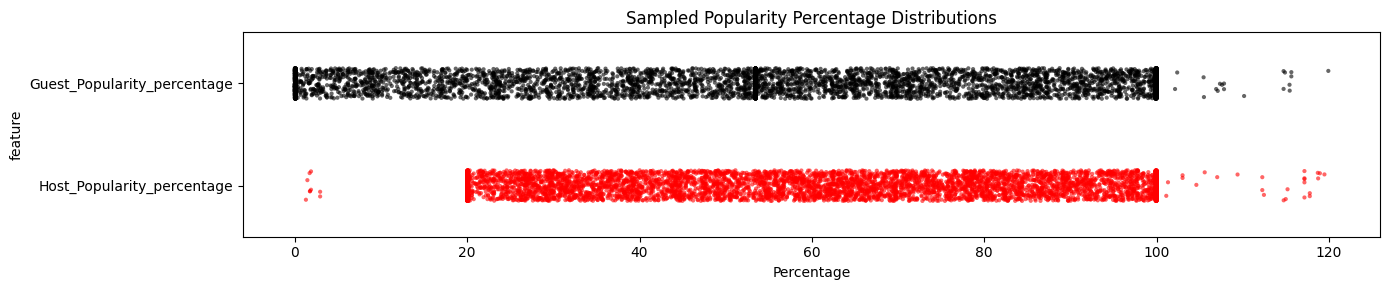

In [24]:
features = ['Guest_Popularity_percentage', 'Host_Popularity_percentage']
plot_df = []

# outliers and middle for each feature
for col in features:
    q1, q99 = train[col].quantile([0.001, 0.999])
    sample = pd.concat([
        train[train[col] < q1][col],
        train[train[col].between(q1, q99)][col].sample(5000, random_state=42),
        train[train[col] > q99][col]
    ])
    plot_df.append(pd.DataFrame({'value': sample, 'feature': col}))

plot_df = pd.concat(plot_df, ignore_index=True)

# plot the distributions
plt.figure(figsize=(14, 3))
sns.stripplot(data=plot_df, x='value', y='feature',
              hue='feature', palette=dict(zip(features, ['black', 'red'])),
              jitter=0.15, size=3, alpha=0.6)


plt.xlabel("Percentage")
plt.yticks(ticks=range(len(features)), labels=features)
plt.title("Sampled Popularity Percentage Distributions")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()


`Number_of_Ads`, `Guest_Popularity_precentage` and `Host_popularity_precentage` are certainly erros or outliearn, and will be removed and cliped

On a side note, Episode Length Minutes has an extreme outlinear, that will also be removed.

In [25]:
train = train[
    (train['Guest_Popularity_percentage'].between(0, 100)) &
    (train['Host_Popularity_percentage'].between(0, 100)) &
    (train['Episode_Length_minutes'].between(0, 120)) 
]
train = train[train['Number_of_Ads'].isin([0, 1, 2, 3])]


# clip values as we need to keep submission set and teset set with the same length
test['Guest_Popularity_percentage'] = test['Guest_Popularity_percentage'].clip(0, 100)
test['Host_Popularity_percentage'] = test['Host_Popularity_percentage'].clip(0, 100)
test['Episode_Length_minutes'] = test['Episode_Length_minutes'].clip(0, 120)

test['Number_of_Ads'] = test['Number_of_Ads'].clip(0, 3)

Now I will look into how differen categories influence listening time

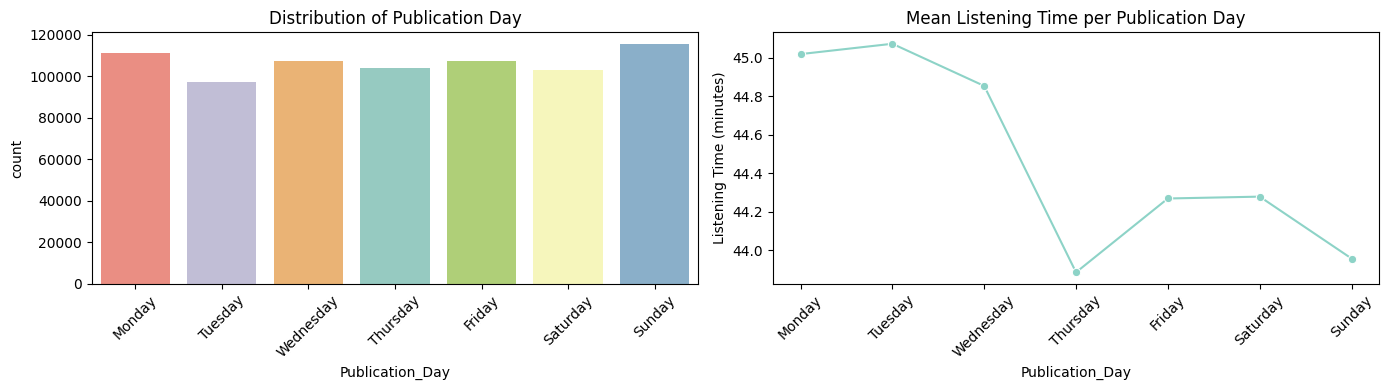

In [26]:

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
set_palette = 'Set3'
day_means = train.groupby('Publication_Day')['Listening_Time_minutes'].mean().reindex(day_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.countplot(data=train, x='Publication_Day', order=day_order, hue='Publication_Day',
              palette=set_palette, ax=axes[0], legend=False)
axes[0].set_title("Distribution of Publication Day")
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(x=day_means.index, y=day_means.values, marker='o', ax=axes[1],
             color=sns.color_palette(set_palette)[0])
axes[1].set_title("Mean Listening Time per Publication Day")
axes[1].set_ylabel("Listening Time (minutes)")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

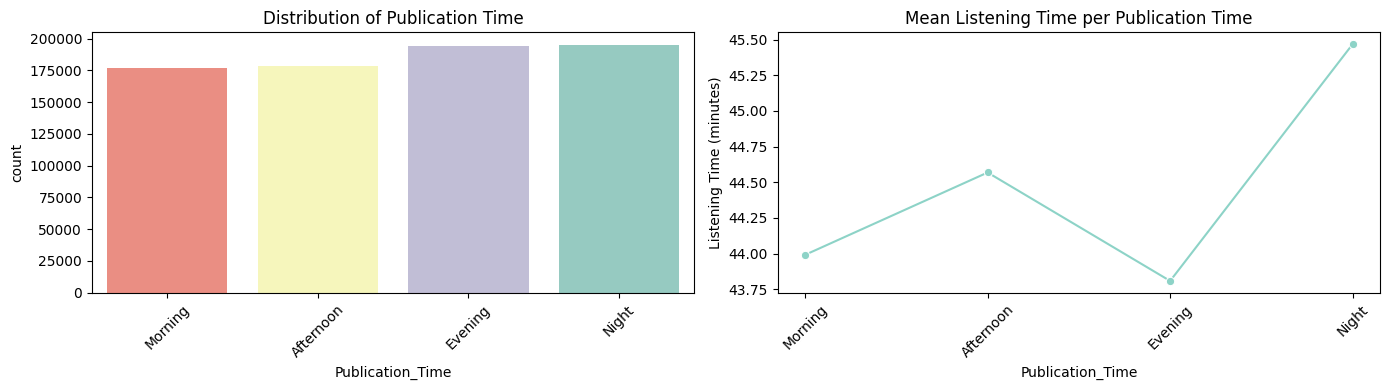

In [27]:
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
time_means = train.groupby('Publication_Time')['Listening_Time_minutes'].mean().reindex(time_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.countplot(data=train, x='Publication_Time', order=time_order, hue='Publication_Time',
              palette=set_palette, ax=axes[0], legend=False)
axes[0].set_title("Distribution of Publication Time")
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(x=time_means.index, y=time_means.values, marker='o', ax=axes[1],
             color=sns.color_palette(set_palette)[0])
axes[1].set_title("Mean Listening Time per Publication Time")
axes[1].set_ylabel("Listening Time (minutes)")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

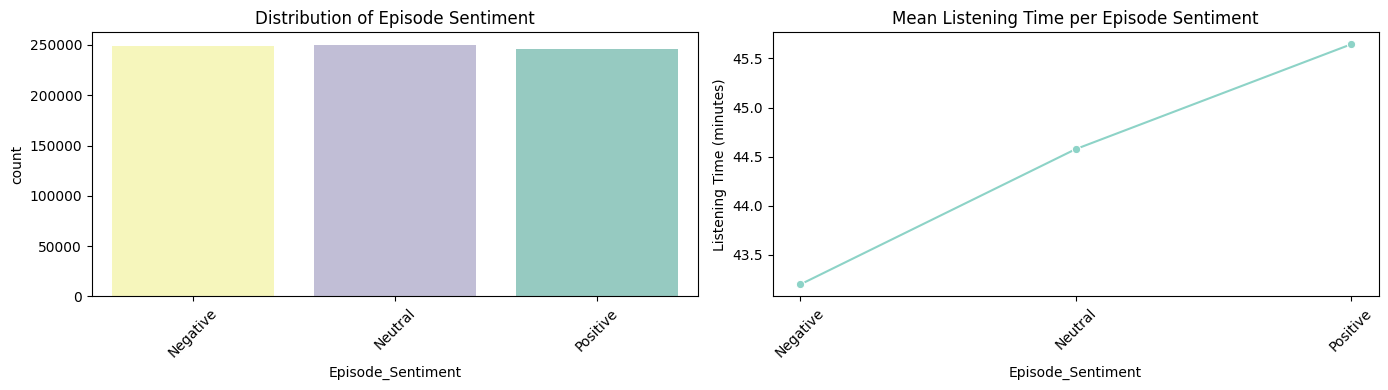

In [28]:
sentiment_order = ['Negative', 'Neutral', 'Positive']
sentiment_means = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().reindex(sentiment_order)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.countplot(data=train, x='Episode_Sentiment', order=sentiment_order, hue='Episode_Sentiment',
              palette=set_palette, ax=axes[0], legend=False)
axes[0].set_title("Distribution of Episode Sentiment")
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(x=sentiment_means.index, y=sentiment_means.values, marker='o', ax=axes[1],
             color=sns.color_palette(set_palette)[0])
axes[1].set_title("Mean Listening Time per Episode Sentiment")
axes[1].set_ylabel("Listening Time (minutes)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Although the distribution of categorical datas appears to be balanced and even, these variables still have strong impact on listening time.

For `Episode_Sentiment`, episodes labeled as *Positive* consistently attract longer listening times compared to *Neutral* or *Negative* ones.

When it comes to `Publication_Time`, listening peaks during the Night, suggesting that users are more engaged with podcast content during after work hours or before bedtime.

And while `Publication_Day` is fairly evenly distributed, average listening time is slightly higher earlier in the week. This might show that users tend to catch up on episodes or follow updates after the weekend, particularly on Mondays and Tuesdays.

---

Since we now see different correlations between data, it will be intersting to look into correlation matrix.

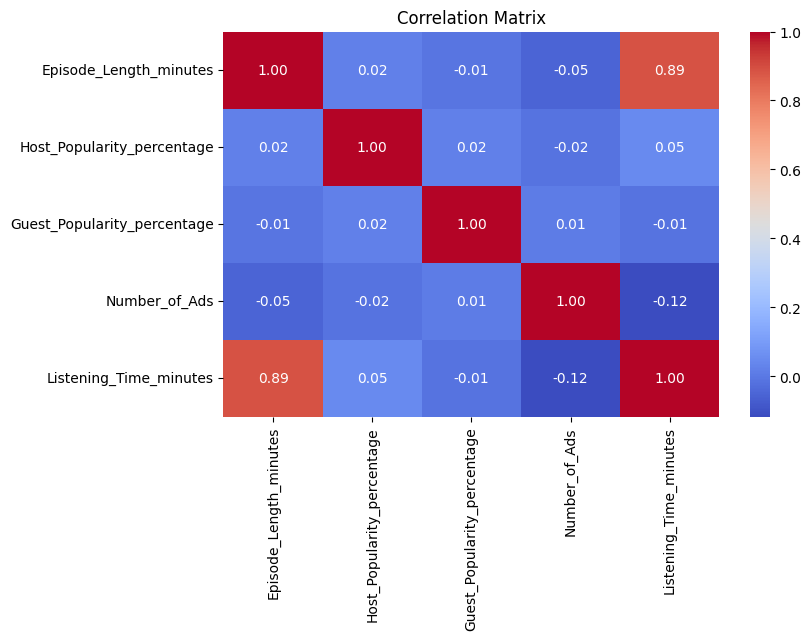

In [29]:
plt.figure(figsize=(8, 5))
sns.heatmap(train.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

`Listening_Time_minutes` shows a strong positive correlation with `Episode_Length_minutes`, meaning that longer episodes are typically listened to for longer.

This  almost linear relationship!


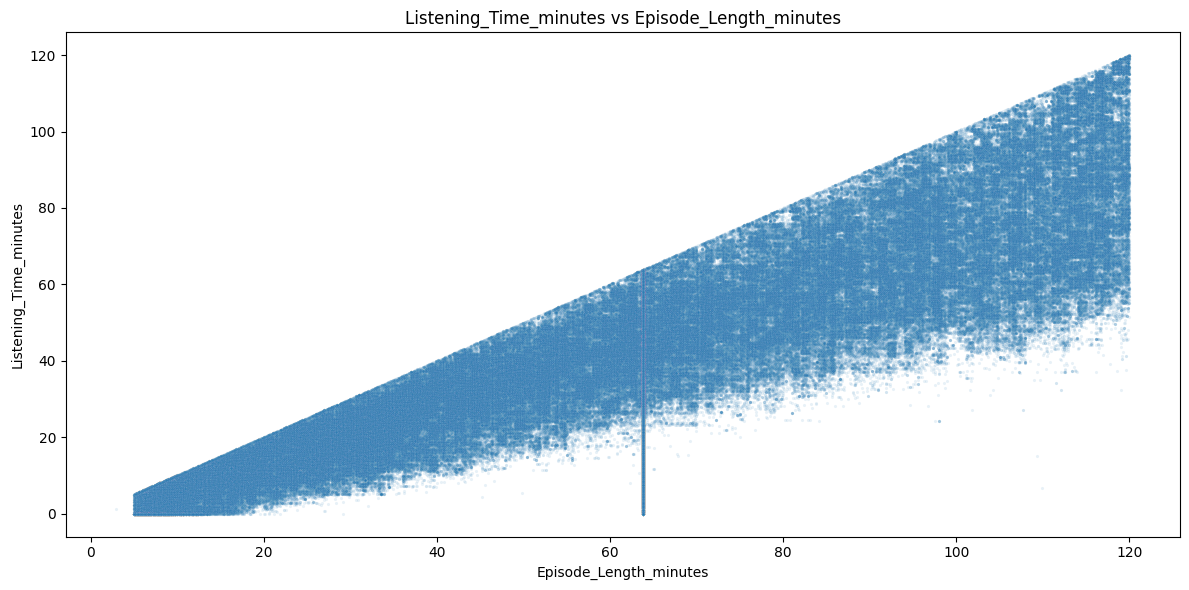

In [30]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=train,
    x='Episode_Length_minutes',
    y='Listening_Time_minutes',
    alpha=0.1,
    s=5
)

plt.title("Listening_Time_minutes vs Episode_Length_minutes")
plt.xlabel("Episode_Length_minutes")
plt.ylabel("Listening_Time_minutes")
plt.tight_layout()
plt.show()

Once again, we observe an almost linear relationship between episode length and listening time. The sharp vertical line visible in the plot is a result of missing `Episode_Length_minutes` values being imputed with the median. 

While this creates a noticeable spike, it should not significantly impact tree-based models, which are less sensitive to feature distribution shapes.

## 4. Data Modelling

In this section, I applied a regression approach to predict podcast Listening Time (in minutes). I used feature engineering, hyperparameter optimization, and cross-validation to improve performance of GXBoost Model.

### 4.1. Feature Selection

During earlier analysis, I identified several categorical and numerical features that could influence listening time. For categorical variables, there are two primary approaches to prepare them for modeling: *one-hot encoding* and *categorical (ordinal) encoding*. 

One-hot encoding expands each category into separate features, which can be useful for linear models but will increase number of dementions. While categorical encoding (or simply mapping weekdays to numbers) retains the compact structure and works well with tree-based models like XGBoost, or RandomForest. 

Due to my model choice and dataset size, I will apply categorical encoding for features such as `Publication_Day`, `Publication_Time`, `Genre`, and `Episode_Sentiment`. Numerical features like `Episode_Length_minutes`, `Popularity`, and `Number_of_Ads` will be used directly, along with two engineered features: `is_weekend` and `working_hours` as it it something thta might influence results in my opinion.

In [31]:
# simpe method that takes any df and returns it with new features: if the say is weekend, and if its within working hours
def add_basic_features(df):
    df = df.copy()
    
    # weekends
    df['is_weekend'] = df['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)

    # (1 if Morning or Afternoon, else 0)
    df['working_hours'] = df['Publication_Time'].isin(['Morning', 'Afternoon']).astype(int)
    
    return df

train = add_basic_features(train)
test = add_basic_features(test)

In [32]:
# to convert dates and timee, i will use simple maping
day_map = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,
    'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
}
time_map = {
    'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4
}

In [33]:
train['Publication_Day'] = train['Publication_Day'].map(day_map)
train['Publication_Time'] = train['Publication_Time'].map(time_map)
train['Genre'] = train['Genre'].astype('category').cat.codes
train['Episode_Sentiment'] = train['Episode_Sentiment'].astype('category').cat.codes

test['Publication_Day'] = test['Publication_Day'].map(day_map)
test['Publication_Time'] = test['Publication_Time'].map(time_map)
test['Genre'] = test['Genre'].astype('category').cat.codes
test['Episode_Sentiment'] = test['Episode_Sentiment'].astype('category').cat.codes

In [34]:
features = [
    'Episode_Length_minutes', 'Host_Popularity_percentage',
    'Guest_Popularity_percentage', 'Number_of_Ads',
    'is_weekend', 'working_hours',
    'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment'
]

X_full = train[features].astype(float)
X_test_full = test[features].astype(float)
y_full = train['Listening_Time_minutes']


### 4.2 Model Construction and Validation

To predict listening time, I used the *XGBoost Regressor* because it handles both numerical and categorical features effectively and typically provides strong performance without requiring extensive preprocessing or tuning.

For hyperparameter tuning, I applied **Optuna**, a framework I'm familiar with. I created a custom objective function that evaluated different combinations of parameters using *3-fold cross-validation*, measuring performance based on *RMSE*. After running 10 trials, Optuna identified the best set of hyperparameters.

With these optimized settings, I trained and validated the model using *5-fold cross-validation*. This process involved training the model on five different train/validation splits of the data, resulting in both *out-of-fold (OOF) predictions* and *test set predictions*. 

Averaging the RMSE scores across the five folds showed a consistent improvement and no unexpected peaks.

This twostep process first tuning, then validating ensures that the final model will be more accurate and robust.

In [45]:
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBRegressor(**params, verbosity=1)
    scores = cross_val_score(model, X_full, y_full, cv=3, scoring='neg_root_mean_squared_error')
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("✅ Best RMSE:", study.best_value)
print("✅ Best parameters:", study.best_params)

[I 2025-05-02 08:12:30,007] A new study created in memory with name: no-name-83f2eca0-b067-41e1-9d52-88c58574570e
[I 2025-05-02 08:13:19,280] Trial 0 finished with value: 11.120659657748632 and parameters: {'learning_rate': 0.13309353120117684, 'max_depth': 6, 'subsample': 0.649351776862946, 'colsample_bytree': 0.8119778093073076, 'min_child_weight': 5}. Best is trial 0 with value: 11.120659657748632.
[I 2025-05-02 08:14:09,924] Trial 1 finished with value: 11.113503527379168 and parameters: {'learning_rate': 0.1983677026818046, 'max_depth': 6, 'subsample': 0.9785281974076333, 'colsample_bytree': 0.8045513608162826, 'min_child_weight': 3}. Best is trial 1 with value: 11.113503527379168.
[I 2025-05-02 08:19:15,713] Trial 2 finished with value: 11.49535453405601 and parameters: {'learning_rate': 0.08434413048418347, 'max_depth': 14, 'subsample': 0.537952550235133, 'colsample_bytree': 0.8952631134748464, 'min_child_weight': 4}. Best is trial 1 with value: 11.113503527379168.
[I 2025-05-02

✅ Best RMSE: 11.072776045666005
✅ Best parameters: {'learning_rate': 0.02310042366917322, 'max_depth': 8, 'subsample': 0.6398641722462723, 'colsample_bytree': 0.9383242634100034, 'min_child_weight': 8}


In [55]:
# using optimized parameters for final model
best_params = study.best_params.copy()
best_params.update({
    'objective': 'reg:squarederror',
    'n_estimators': 1000,
    'tree_method': 'hist',
    'random_state': 42
})

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X_full))
test_preds = np.zeros(len(X_test_full))
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_full)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]

    model = xgb.XGBRegressor(**best_params, early_stopping_rounds=50)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )
    
    val_preds = model.predict(X_val)
    oof_preds[val_idx] = val_preds
    rmse = mean_squared_error(y_val, val_preds) ** 0.5
    rmse_scores.append(rmse)
    print(f"Fold RMSE: {rmse:.4f}")
    
    test_preds += model.predict(X_test_full) / kf.n_splits

    
final_rmse = np.mean(rmse_scores)
print(f"\n✅ Overall CV RMSE: {final_rmse:.4f}")


--- Fold 1 ---
[0]	validation_0-rmse:26.77251
[100]	validation_0-rmse:11.52777
[200]	validation_0-rmse:11.13910
[300]	validation_0-rmse:11.10362
[400]	validation_0-rmse:11.08551
[500]	validation_0-rmse:11.07086
[600]	validation_0-rmse:11.05970
[700]	validation_0-rmse:11.04933
[800]	validation_0-rmse:11.04194
[900]	validation_0-rmse:11.03539
[999]	validation_0-rmse:11.02866
Fold RMSE: 11.0287

--- Fold 2 ---
[0]	validation_0-rmse:26.72029
[100]	validation_0-rmse:11.55466
[200]	validation_0-rmse:11.18782
[300]	validation_0-rmse:11.15521
[400]	validation_0-rmse:11.13473
[500]	validation_0-rmse:11.12053
[600]	validation_0-rmse:11.11040
[700]	validation_0-rmse:11.10118
[800]	validation_0-rmse:11.09286
[900]	validation_0-rmse:11.08568
[999]	validation_0-rmse:11.08017
Fold RMSE: 11.0802

--- Fold 3 ---
[0]	validation_0-rmse:26.73259
[100]	validation_0-rmse:11.54108
[200]	validation_0-rmse:11.16749
[300]	validation_0-rmse:11.13258
[400]	validation_0-rmse:11.11210
[500]	validation_0-rmse:11.09

### 4.3 Model Application and Performance Evaluation

Saving the model for Kaggle submition. The submition files received `13.51040` for private, and `13.69104` for public score. 

The difference between those two is that Kaggle simply uses from 20-50% of test data form their side to verify score, and only private score is displyed in final competition leaderboard.

At the moment, competition has ended, and the top score is `11.44833`.

In [56]:
# loading submission template
submission = pd.read_csv("data/sample_submission.csv")

# adding model predictions
submission['Listening_Time_minutes'] = test_preds

name = 'GXBoostOptunaSubmission'

# to file
submission.to_csv(f"data/{name}.csv", index=False)

print(f"✅ Submission saved as '{name}.csv'")

✅ Submission saved as 'GXBoostOptunaSubmission.csv'


### 4.4 Visualize and Analyze Your Results/Findings from Data Modelling

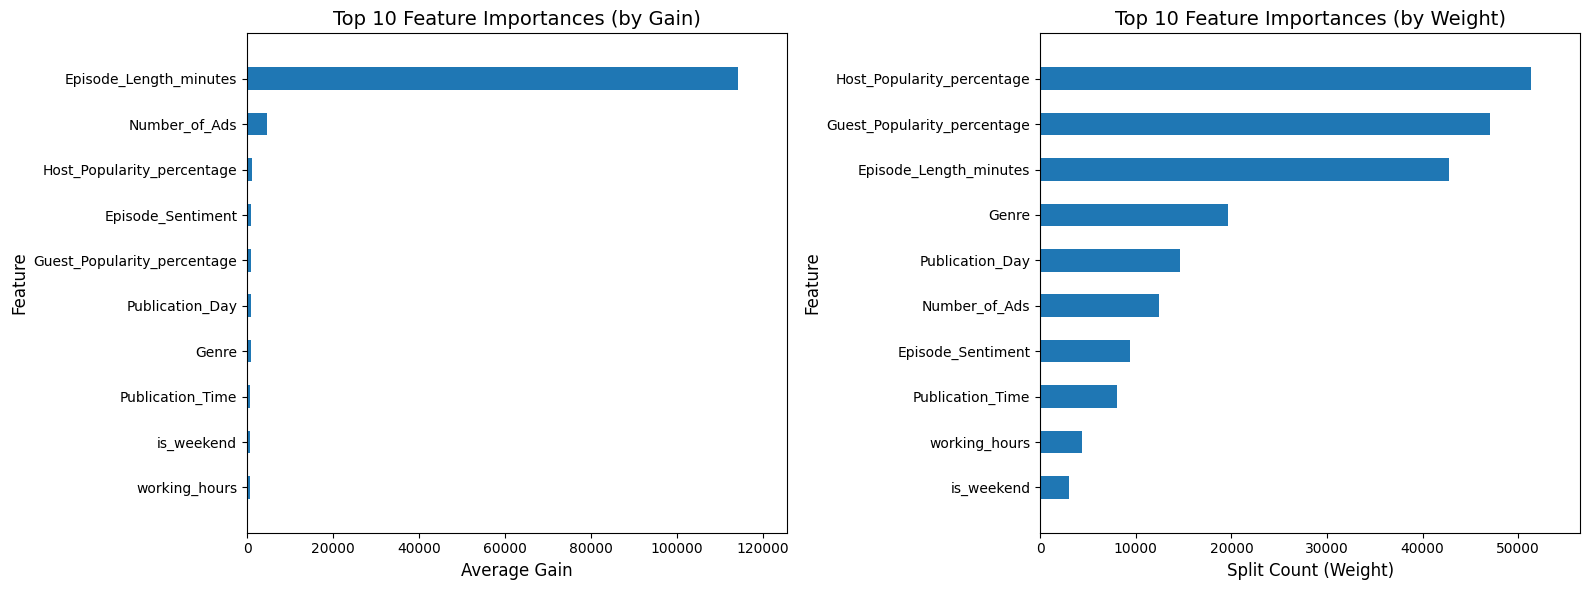

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# gain plot
xgb.plot_importance(
    model,
    ax=axes[0],
    importance_type='gain',
    max_num_features=10,
    height=0.5,
    grid=False,
    show_values=False
)
axes[0].set_title("Top 10 Feature Importances (by Gain)", fontsize=14)
axes[0].set_xlabel("Average Gain", fontsize=12)
axes[0].set_ylabel("Feature", fontsize=12)

# weight plot
xgb.plot_importance(
    model,
    ax=axes[1],
    importance_type='weight',
    max_num_features=10,
    height=0.5,
    grid=False,
    show_values=False
)
axes[1].set_title("Top 10 Feature Importances (by Weight)", fontsize=14)
axes[1].set_xlabel("Split Count (Weight)", fontsize=12)
axes[1].set_ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()


Looking at the figure above, I can see the feature importance from my XGBoost model in two ways. The plot on the left shows importance based on '*gain*'. This basically tells me how much the model's accuracy improves whenever a feature is used to make a split in the trees. This plot makes it super clear that `Episode_Length_minutes` is by far the most important feature. 

It helps the model way more than anything else. This wasn't a huge surprise, especially after seeing its strong correlation with listening time and that side-by-side plot earlier.

On the other hand, the plot on the right shows importance by '*weight*'. This just counts how many times each feature gets used across all the trees in the model. According to this one, features like `Host_Popularity_percentage` and `Guest_Popularity_percentage` are used the most often, even if they don't actually improve the prediction quality as much each time they're used.

The '*gain*'based importance is usually better for figuring out what's really driving the model's performance, as it looks at the actual impact, not just how often a feature pops up.

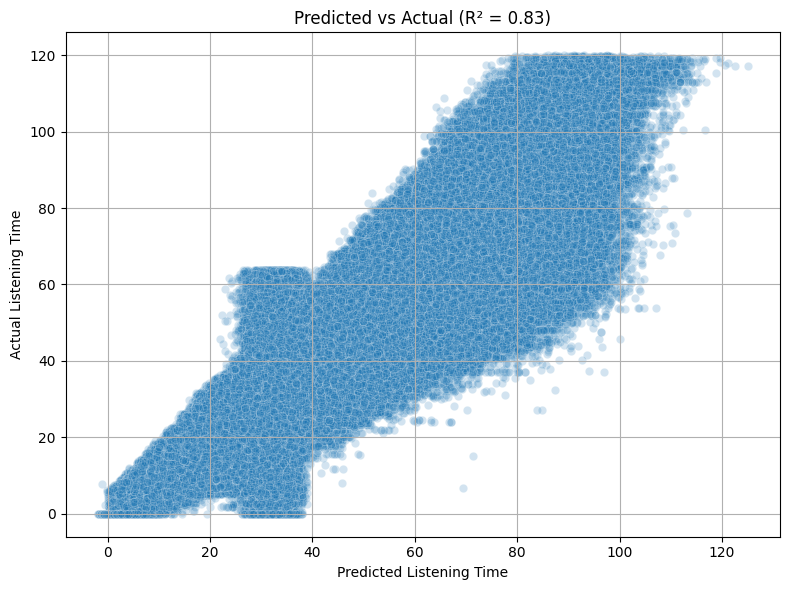

In [58]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=oof_preds, y=y_full, alpha=0.2)
plt.xlabel("Predicted Listening Time")
plt.ylabel("Actual Listening Time")
plt.title(f"Predicted vs Actual (R² = {r2_score(y_full, oof_preds):.2f})")
plt.grid(True)
plt.tight_layout()
plt.show()

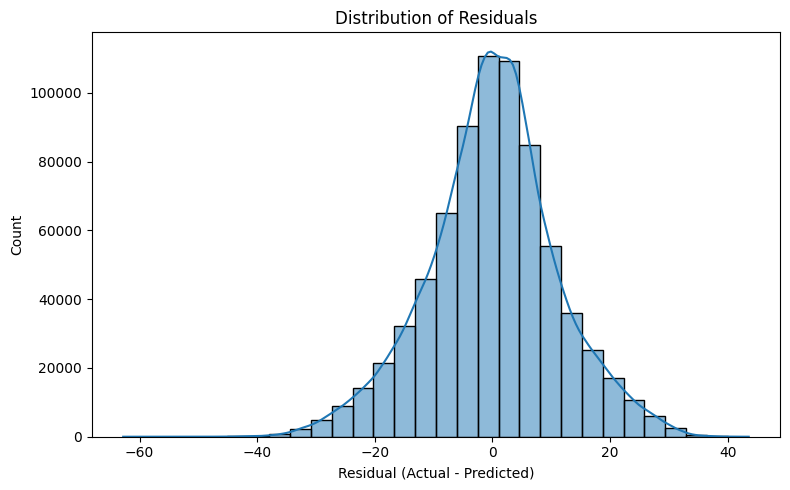

In [59]:
residuals = y_full - oof_preds

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()


## 5. Conclusion and Discussion

For this project, I applied machine learning techniques to predict podcast listening time based on episode and contextual features. Following feature engineering and encoding, I selected the XGBoost Regressor due to its strong performance with structured data. Utilizing Optuna for hyperparameter tuning and evaluating the model through 5-fold cross-validation, I achieved a robust average root mean squared error (RMSE) and a high $R^2$ score of **0.83**.

Visualizations of the differences between the predicted and actual values confirmed that the model made accurate predictions across a range of listening times, with some underestimations for certain data segments. Feature importance plots revealed that episode length and host popularity were significant predictors of listening behavior.

Visualizations comparing predicted and actual values confirmed that my model produced accurate predictions across a range of listening times, though with some minor underestimations for certain data segments.

Feature importance plots indicated that episode length and host popularity were significant predictors of listening behavior.I also observed notable patterns within the data itself. While categorical features (such as sentiment or time of day) were relatively balanced, they still demonstrated an impact on the target variable. For instance, episodes with a positive sentiment consistently showed higher listening times compared to neutral or negative ones. Similarly, listeners tended to engage more during the night, likely reflecting post-work relaxation. Listening activity was also slightly elevated earlier in the week, suggesting users may catch up on content after the weekend.

My analysis, including the correlation matrix and various plots, confirmed a strong positive linear relationship between `Episode_Length_minutes` and `Listening_Time_minutes`, with a correlation coefficient of 0.89. This relationship appeared nearly linear

Finally, feature importance plots showed that while `Host_Popularity_percentage` and `Guest_Popularity_percentage` were frequently used in decision trees (high weight), their actual contribution to prediction rate (gain) was small. In contrast, `Episode_Length_minutes` had big impact on prediction quality, as showed by both gain-based importance and the observed correlation.

I achieved a respectable score on Kaggle's private leaderboard, with a private score of **13.51040** and a public score of **13.69104**. These results can be verified through the submission file available in the [GitHub repository](https://github.com/rifolio/PodcastWatchTimePrediction) under `data/GXBoost.OptunaSubmition.csv` and by uploading it to the official [Kaggle competition page](https://www.kaggle.com/competitions/playground-series-s5e4/submissions).


Overall, this project demonstrates that tree-based models like XGBoost can deliver good prediction on such complex data, especially when combined with good feature engineering, visuals and proper validation.